#### *Deep Learning with Python* Chapter 6: Deep Learning for Texts and Sequences
##### *Notebook by Jacob Kreider*

*The below code is pulled directly from Deep Learning with Python by Francois Chollet (Manning Publications, 2018). Code comments, notes, and commentary are a mix of mine and the book author's. I will put anything directly from the book in quotes, with the exception of code comments. They might be mine, might be his.*

This chapter covers both RNNs (recurrent neural networks) and 1D convnets (CNNs, hereafter) for text processing and timeseries prediction/classification. 

"
Applications of these algorithms include the following:

* Document classification and timeseries classification, such as identifying the topic of an article or the author of a book
* Timeseries comparisons, such as estimating how closely related two documents or two stock tickers are
* Sequence-to-sequence learning, such as decoding an English sentence into French
* Sentiment analysis, such as classifying the sentiment of tweets or movie reviews as positive or negative
* Timeseries forecasting, such as predicting the future weather at a certain location, given recent weather data"

Example networks in this chapter are: sentiment analysis using the IMDb dataset and temperature forecasting.

### 6.1 Working with text data

The methods we use here are for very basic NLP-- good enough for doc classifiers, author identifications, etc. This doesn't give a deep understanding of text, but does "map the statistical structureof written language" which is enough for our examples here.

As with images, we need to convert the raw text into numeric tensors, by *vectorizing* the text. this can be done by:
* Segmenting the text into words, then transforming each word into a vector
* Segmenting the text into characters, then transforming each character in a vector; or,
* Extract *n-grams* (overlapping groups of multiple consecutive words/characters) and transforming each n-gram into a character

***Tokens***: the different units that text can be broken into (i.e words, characters, or n-grams)

***Tokenization***: the process of creating these tokens from the text

How to associate vectors with tokens: one-hot encoding and token embedding

*See chapter section for a detailed explanation of how n-gram tokenization works.* But, one thing to remember is that bag-of-words models (the term for using n-gram tokenization) doesn't preserve word order overall. It just creates a set of the n-gram combinations. As such, it is better for shallow language processing than deep learning. Bag-of-words is a step of *feature engineering*, which deep learning tries to minimize and handle on its own.

#### 6.1.1 One-hot encoding of words and characters

Most common way to turn a token into a vector. Associates a unique integer index with every word, then creating a binary vector with size N = to the size of the vocabulary with all zeros except for a 1 in the *i*th entry.

Let's give it a shot:





In [7]:
# Listing 6.1 Word-level one-hot encoding (toy example)

import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenIndex = {} # Empty index for all the tokens in samples
for sample in samples:
    for word in sample.split(): # splits apart all the words. Could also remove puncuation/common words
        if word not in tokenIndex:
            tokenIndex[word] = len(tokenIndex) + 1 # assigns an index at each word, ignores index[0]
            
maxLength = 10 # This limits the length of the vector. So, here, only first 10 words of each sample are used

# Create a place to store the results
results = np.zeros(shape = (len(samples)
                            , maxLength
                           , max(tokenIndex.values()) + 1))

# one-hot encode the tokenIndex

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:maxLength]:
        index = tokenIndex.get(word)
        results[i, j, index] = 1.


In [2]:
# Listing 6.2 Character-level one-hot encoding (toy example)

import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

characters = string.printable
tokenIndex = dict(zip(range(1, len(characters) + 1), characters))

maxLength = 50

results = np.zeros((len(samples), maxLength, max(tokenIndex.keys()) + 1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = tokenIndex.get(character)
        results[i, j, index] = 1.

We can use keras' built-in one-hot encoding. It strips out special characters and only considers the N most common words in the data (a commonly used restriction)

In [5]:
# Listing 6.3 Using Keras for word-level one-hot encoding

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

oneHotResults = tokenizer.texts_to_matrix(samples, mode = 'binary')

wordIndex = tokenizer.word_index
print('Found %s unique tokens.' % len(wordIndex))

Found 9 unique tokens.


For data where the number of unique tokens is extremely large, we can use *one-hot hashing trick* which hashes words into vectors of fixed size, rather than assigning an index to each.

To avoid having multiple words assigned to the same has (called *hash collisions*), the dimensionality of the hashing space should be much larger than the total number of unique tokens.

In [9]:
# Listing 6.4 Word-level one-hot encoding with hashing trick

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000 # if we had close to 1K words, there'd be a ton of hash collisions
maxLength = 10

results = np.zeros((len(samples), maxLength, dimensionality))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:maxLength]:
        index = abs(hash(word)) % dimensionality # hashes the word into random in b/w 1 and 1000
        results[i, j, index] = 1.

#### 6.1.2 Using word embeddings

One-hot encoding creates *binary, sparse, and high dimensional* vectors, word embeddings are low-dimensional floating-point vectors (i.e. dense vectors). In essence, word embeddings "pack more information into far fewer dimensions."

Two ways to obtain:

1) "Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network."

2) "Load into your model word embeddings that were precomputed using a different machine-learning task than the one you’re trying to solve. These are called *pretrained word embeddings*."

###### Learning word embeddings with the Embedding Layer

The geometric relationships between words should refelct the semantic relationships. For example, "accurate" and "exact" should be similarly embedded. So, we should account for both geometric distance (as in *exact* and *precise*), as well as direction (as in *cat* to *tiger*).

When done correctly, we should be able to make meaningful transformations (e.g. adding *female* to *king* == *queen*). This is obviously very task dependent. So, it makes sense to learn a new embedding space with each new task, and this can be done relatively easily, thanks to our old friend backpropagation.



In [10]:
# List 6.5 Instantiating an Embedding Layer with keras

from keras.layers import Embedding

embeddingLayer = Embedding(1000, 64)

We can think of the embedding layer as "a dictionary that maps integer indices (which stand for specific words) to dense vectors...it is effectively a dictionary lookup."

Word Index ------> Embedding Layer -----> Corresponding word vector

The Embedding Layer takes a 2D tensor of integers as input (shape = (samples, sequenceLength)). Because they get packed into a single tensor, shorter sequences should be padded with zeros and longer ones should be truncated (if need be, depending on batch size).

The Embedding Layer returns a 3D floating-point tensor of shape(samples, sequenceLength, embeddingDimensionality), which can then be processed by RNNs and 1D CNNs.

When an Embedding Layer is instantiated, as above, it starts with random weights, and then they are adjusted via backprop, just like a normal network.

Now, we'll apply this to the IMDb data:

In [12]:
# Listing 6.6 Loading the IMDb data for use with Embedding Layer

from keras.datasets import imdb
from keras import preprocessing

# Set the number of words to consider as features
maxFeatures = 10000
# Cuts off the text after this number of words
maxlen = 20

(xTrain, yTrain), (xTest, yTest) = imdb.load_data(
    num_words = maxFeatures)

# Turn the list of integers into a 2D integer tensor, shape(samples, maxlen)
xTrain = preprocessing.sequence.pad_sequences(xTrain, maxlen = maxlen)
xTest = preprocessing.sequence.pad_sequences(xTest, maxlen = maxlen)

In [13]:
# Listing 6.7 Using an Embedding LAyer and classifier on the IMDb data

from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# Sepcify the max inout length to the Embed layer,so we can flatten the inputs later
# Activations after this layer wil have shae(samples, maxlen, 8)
model.add(Embedding(10000, 8, input_length = maxlen))

# Flatten the 3D tensor output from the Embedding layer into
# a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# Now, we'll add the classifier
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

history = model.fit(xTrain, yTrain
                   , epochs = 10
                   , batch_size = 32
                   , validation_split = 0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 103us/step - loss: 0.6759 - acc: 0.6051 - val_loss: 0.6399 - val_acc: 0.6806
Epoch 2/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.5660 - acc: 0.7429 - val_loss: 0.5470 - val_acc: 0.7194
Epoch 3/10
20000/20000 [==============================] - 2s 78us/step - loss:

The really basic model above gave us ~75% accuracy. Pretty good, considering we were only looking at the first 20 words in each review.

What it *didn't* do was account for any inter-word relationships. It saw all words as standalone. Adding recurrent or 1D convolutional layers on top will help learn features that account for the meanings of sequences of words.

###### Using pretrained word embeddings

IF you don't have enough data to learn the embedding space on your own, you can download highly structured, pretrained word embeddings. Some example of these pretraining embedding spaces are Word2Vec and GloVe.

#### 6.1.3 Putting it all together: from raw text to word embeddings

Start this section by downloading and installing the raw IMDb dataset from [here](http://mng.bz/0tIo) . Change path in Listing 6.8 to local directory.

In [5]:
# Listing 6.8 Processing the labels of the raw IMDb data

import os
imdbDir = '/home/jacob/MSDS-git/msds458/Data/imdb/aclImdb'
trainDir = os.path.join(imdbDir, 'test')

labels = []
texts = []

# Pull in data from 'pos' and 'neg' directories and label each review file as such
for label_type in ['neg', 'pos']:
    dirName = os.path.join(trainDir, label_type)
    for fname in os.listdir(dirName):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dirName, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)



In [8]:
# Now, we'll vectorize the text and create training and validation
# sets. We'll also restrict to 200 samples (since the point of
# using pretrained embeddings is because you have limited samples)

# Listing 6.9 Tokenizing the test of the raw IMDb data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # only uses first 100 words
trainingSamples = 200 # only trains on 200 samples
validationSamples = 10000 # validates on 10K samples
maxWords = 10000 # uses only top 10K words

tokenizer = Tokenizer(num_words = maxWords)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

wordIndex = tokenizer.word_index
print('Found %s unique tokens.' % len(wordIndex))

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices) # shuffle the data so it isn't ordered positive to negative
data = data[indices]
labels = labels[indices]

xTrain = data[:trainingSamples]
yTrain = labels[:trainingSamples]
xVal = data[trainingSamples: trainingSamples + validationSamples]
yVal = labels[trainingSamples: trainingSamples + validationSamples]

Found 72633 unique tokens.
Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


###### Download GloVe word embeddings

Go [here](https://nlp.stanford.edu/projects/glove) and download the zip file glove.6B.zip. Unzip it, we'll be using the glove.6B.100d.txt file.

Change the path below to reflect where it's stored.

In [9]:
# Listing 6.10 Parsing the GloVe word-embeddings file

gloveDir = '/home/jacob/MSDS-git/msds458/Data/glov'

embeddingsIndex = {}
f = open(os.path.join(gloveDir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddingsIndex[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddingsIndex))

Found 400000 word vectors.


In [10]:
# Next, we build an embedding matrix that we can pass to
# the embedding layer. 

# Listing 6.11 Preparing the GloVe word embeddings matrix

embeddingDim = 100

embeddingMatrix = np.zeros((maxWords, embeddingDim))

for word, i in wordIndex.items():
    if i < maxWords:
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            embeddingMatrix[i] = embeddingVector

###### Defining a model

We'll use the same architecture we did in the last section

In [12]:
# Listing 6.12 Model Definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(maxWords, embeddingDim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Listing 6.13 Loading pretrained word embeddings into the Embedding layer

model.layers[0].set_weights([embeddingMatrix])
model.layers[0].trainable = False

We set the trainable parameter to false above because these are pretrained weights...we don't want the model forgetting what it already knows by updating these weights.

###### Training and evaluating the model:

In [14]:
# Listing 6.14 Training and evaluation

model.compile(optimizer = 'rmsprop'
             , loss = 'binary_crossentropy'
             , metrics = ['acc'])
history = model.fit(xTrain, yTrain
                   , epochs = 10
                   , batch_size = 32
                   , validation_data = (xVal, yVal))
model.save_weights('pretrainedGloveModel.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.2408 - acc: 0.5100 - val_loss: 0.6183 - val_acc: 0.7234
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5642 - acc: 0.7250 - val_loss: 0.6155 - val_acc: 0.7167
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4324 - acc: 0.8400 - val_loss: 0.9223 - val_acc: 0.2761
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3563 - acc: 0.8450 - val_loss: 0.6976 - val_acc: 0.5316
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2960 - acc: 0.9250 - val_loss: 0.5861 - val_acc: 0.7225
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1867 - acc: 0.9600 - val_loss: 0.7917 - val_acc: 0.7258
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1746 - acc: 0.9500 - val_loss: 0.5940 - val_acc: 0.7043
Epoch 8/10
200/200 [========

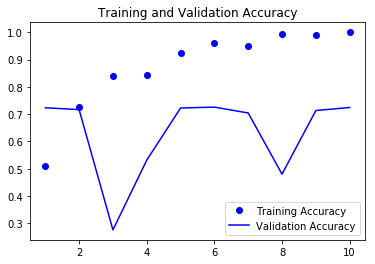

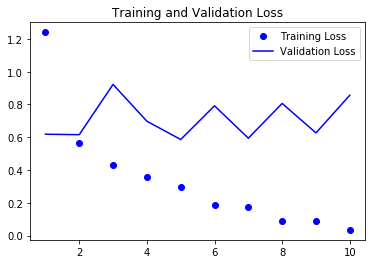

In [16]:
# Listing 6.15 Plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
valAcc = history.history['val_acc']
loss = history.history['loss']
valLoss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, valAcc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, valLoss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Crazy overfitting, due to the tiny number of training samples. In the book, he re-runs the model without the pretrained embeddings, and unsurprisingly gets much worse validation accuracy. I won't re-create here, as that's pretty intuitive.

#### 6.1.4 Wrapping up

In this section, we learned to:
* Turn raw text into tensors that a neural network can ingest
* Use *Embedding* layers in keras to learn token embeddings
* Use pretrained word embeddings in cases where we don't have much data to pass to NLP problems

### 6.2 Understanding recurrent neural networks